# Dataset Structure Analysis

This notebook analyzes the structure of the three datasets (DBLP, ACM, IMDB) used in the Graph Transformer Networks paper.

In [2]:
import pickle
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Dataset paths
DATA_PATH = 'data'
DATASETS = ['DBLP', 'ACM', 'IMDB']

## 1. Load and Inspect All Datasets

In [4]:
def load_dataset(dataset_name):
    """Load all pickle files for a dataset."""
    with open(f'{DATA_PATH}/{dataset_name}/node_features.pkl', 'rb') as f:
        node_features = pickle.load(f)
    with open(f'{DATA_PATH}/{dataset_name}/edges.pkl', 'rb') as f:
        edges = pickle.load(f)
    with open(f'{DATA_PATH}/{dataset_name}/labels.pkl', 'rb') as f:
        labels = pickle.load(f)
    return node_features, edges, labels

# Load all datasets
datasets = {}
for name in DATASETS:
    datasets[name] = load_dataset(name)
    print(f"Loaded {name}")

Loaded DBLP
Loaded ACM
Loaded IMDB


/var/folders/ty/93drpk3520n8xlx9z19j220w0000gr/T/ipykernel_31289/10934543.py:6: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  edges = pickle.load(f)
/var/folders/ty/93drpk3520n8xlx9z19j220w0000gr/T/ipykernel_31289/10934543.py:6: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  edges = pickle.load(f)


## 2. Summary Statistics Table

In [18]:
def get_dataset_stats(name, node_features, edges, labels):
    """Extract statistics from a dataset."""
    train_labels = np.array(labels[0])
    valid_labels = np.array(labels[1])
    test_labels = np.array(labels[2])
    
    num_classes = len(np.unique(np.concatenate([train_labels[:, 1], valid_labels[:, 1], test_labels[:, 1]])))
    total_edges = sum(e.nnz for e in edges)
    
    return {
        'Dataset': name,
        '# Nodes': node_features.shape[0],
        '# Features': node_features.shape[1],
        '# Edge Types': len(edges),
        '# Total Edges': total_edges,
        '# Classes': num_classes,
        '# Training': len(train_labels),
        '# Validation': len(valid_labels),
        '# Test': len(test_labels),
    }

# Create summary table
stats_list = []
for name in DATASETS:
    node_features, edges, labels = datasets[name]
    stats_list.append(get_dataset_stats(name, node_features, edges, labels))

summary_df = pd.DataFrame(stats_list)
summary_df.set_index('Dataset', inplace=True)
print("=" * 80)
print("DATASET SUMMARY (Matching Paper Table 1)")
print("=" * 80)
summary_df

DATASET SUMMARY (Matching Paper Table 1)


,# Nodes,# Features,# Edge Types,# Total Edges,# Classes,# Training,# Validation,# Test
Dataset,,,,,,,,
DBLP,18405,334,4,67946,4,800,400,2857
ACM,8994,1902,4,25922,3,600,300,2125
IMDB,12772,1256,4,37288,3,300,300,2339


## 3. Node Features Analysis

In [6]:
print("=" * 80)
print("NODE FEATURES ANALYSIS")
print("=" * 80)

for name in DATASETS:
    node_features, edges, labels = datasets[name]
    print(f"\n--- {name} ---")
    print(f"Shape: {node_features.shape}")
    print(f"Type: {type(node_features).__name__}, dtype: {node_features.dtype}")
    print(f"Min: {node_features.min():.4f}, Max: {node_features.max():.4f}")
    print(f"Mean: {node_features.mean():.4f}, Std: {node_features.std():.4f}")
    
    # Check sparsity of features
    sparsity = (node_features == 0).sum() / node_features.size * 100
    print(f"Feature Sparsity: {sparsity:.2f}%")
    
    # Check for binary features
    unique_vals = np.unique(node_features)
    if len(unique_vals) <= 10:
        print(f"Unique values: {unique_vals}")
    else:
        print(f"Number of unique values: {len(unique_vals)}")

NODE FEATURES ANALYSIS

--- DBLP ---
Shape: (18405, 334)
Type: ndarray, dtype: int32
Min: 0.0000, Max: 1.0000
Mean: 0.0169, Std: 0.1288
Feature Sparsity: 98.31%
Unique values: [0 1]

--- ACM ---
Shape: (8994, 1902)
Type: ndarray, dtype: int64
Min: 0.0000, Max: 1.0000
Mean: 0.0577, Std: 0.2331
Feature Sparsity: 94.23%
Unique values: [0 1]

--- IMDB ---
Shape: (12772, 1256)
Type: ndarray, dtype: float32
Min: 0.0000, Max: 1.0000
Mean: 0.0043, Std: 0.0653
Feature Sparsity: 99.57%
Unique values: [0. 1.]


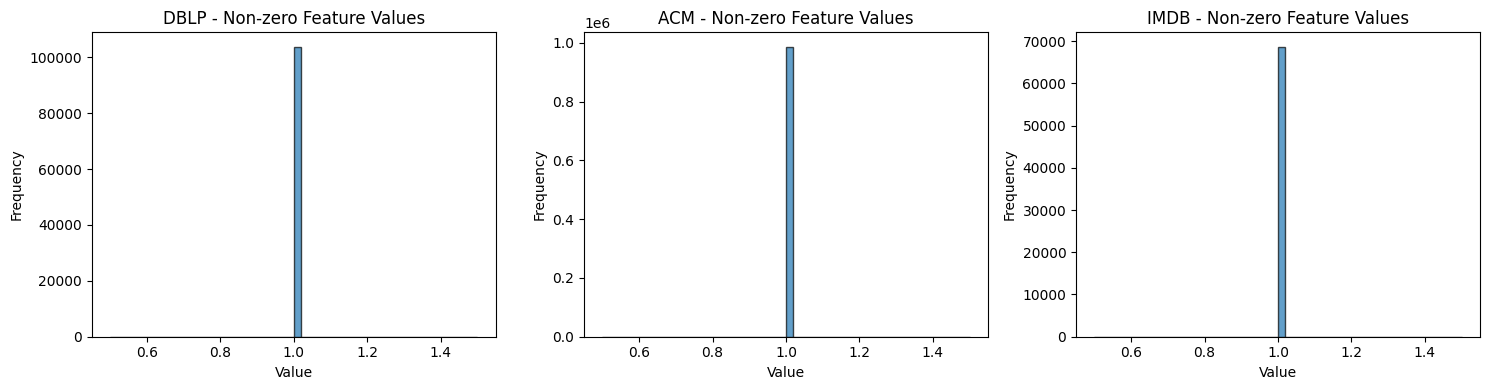

In [7]:
# Visualize feature distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, name in enumerate(DATASETS):
    node_features, _, _ = datasets[name]
    
    # Flatten and sample for histogram
    flat_features = node_features.flatten()
    non_zero = flat_features[flat_features != 0]
    
    axes[idx].hist(non_zero, bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{name} - Non-zero Feature Values')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 4. Edge Types Analysis

In [ ]:
# Edge type names based on dataset schema
EDGE_TYPE_NAMES = {
    'DBLP': ['Paper-Author (PA)', 'Author-Paper (AP)', 'Paper-Conf (PC)', 'Conf-Paper (CP)'],
    'ACM': ['Paper-Author (PA)', 'Author-Paper (AP)', 'Paper-Subject (PS)', 'Subject-Paper (SP)'],
    'IMDB': ['Movie-Director (MD)', 'Director-Movie (DM)', 'Movie-Actor (MA)', 'Actor-Movie (AM)'],
}

print("=" * 80)
print("EDGE TYPES ANALYSIS")
print("=" * 80)

for name in DATASETS:
    node_features, edges, labels = datasets[name]
    print(f"\n--- {name} ---")
    print(f"Number of edge types: {len(edges)}")
    
    edge_names = EDGE_TYPE_NAMES.get(name, [f'Type {i}' for i in range(len(edges))])
    
    for i, edge in enumerate(edges):
        edge_name = edge_names[i] if i < len(edge_names) else f'Type {i}'
        print(f"  {edge_name}:")
        print(f"    Shape: {edge.shape}")
        print(f"    Format: {type(edge).__name__}")
        print(f"    # Edges: {edge.nnz}")
        print(f"    Density: {edge.nnz / (edge.shape[0] * edge.shape[1]) * 100:.4f}%")

EDGE TYPES ANALYSIS

--- DBLP ---
Number of edge types: 4
  Paper-Author (PA):
    Shape: (18405, 18405)
    Format: csr_matrix
    # Edges: 19645
    Density: 0.0058%
  Author-Paper (AP):
    Shape: (18405, 18405)
    Format: csc_matrix
    # Edges: 19645
    Density: 0.0058%
  Paper-Conf (PC):
    Shape: (18405, 18405)
    Format: csr_matrix
    # Edges: 14328
    Density: 0.0042%
  Conf-Paper (CP):
    Shape: (18405, 18405)
    Format: csc_matrix
    # Edges: 14328
    Density: 0.0042%

--- ACM ---
Number of edge types: 4
  Paper-Author (PA):
    Shape: (8994, 8994)
    Format: csr_matrix
    # Edges: 9936
    Density: 0.0123%
  Author-Paper (AP):
    Shape: (8994, 8994)
    Format: csc_matrix
    # Edges: 9936
    Density: 0.0123%
  Paper-Subject (PS):
    Shape: (8994, 8994)
    Format: csr_matrix
    # Edges: 3025
    Density: 0.0037%
  Subject-Paper (SP):
    Shape: (8994, 8994)
    Format: csc_matrix
    # Edges: 3025
    Density: 0.0037%

--- IMDB ---
Number of edge types: 4
 

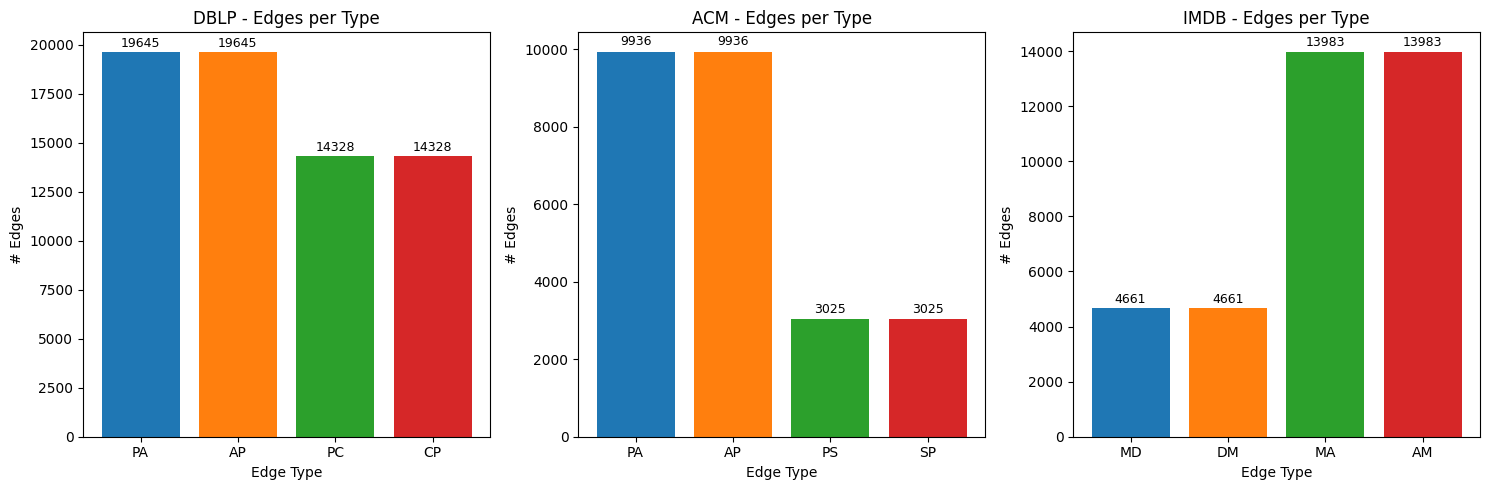

In [9]:
# Visualize edge type distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, name in enumerate(DATASETS):
    _, edges, _ = datasets[name]
    edge_names = EDGE_TYPE_NAMES.get(name, [f'Type {i}' for i in range(len(edges))])
    edge_counts = [e.nnz for e in edges]
    
    bars = axes[idx].bar(range(len(edges)), edge_counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axes[idx].set_title(f'{name} - Edges per Type')
    axes[idx].set_xlabel('Edge Type')
    axes[idx].set_ylabel('# Edges')
    axes[idx].set_xticks(range(len(edges)))
    axes[idx].set_xticklabels([en.split('(')[1].replace(')', '') for en in edge_names], rotation=0)
    
    # Add value labels on bars
    for bar, count in zip(bars, edge_counts):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
                      str(count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 5. Labels Analysis

In [10]:
print("=" * 80)
print("LABELS ANALYSIS")
print("=" * 80)

for name in DATASETS:
    node_features, edges, labels = datasets[name]
    print(f"\n--- {name} ---")
    
    train_labels = np.array(labels[0])
    valid_labels = np.array(labels[1])
    test_labels = np.array(labels[2])
    
    print(f"Labels format: list of 3 arrays [train, valid, test]")
    print(f"Each array shape: [num_samples, 2] where columns are [node_idx, class_label]")
    print(f"\nTrain labels shape: {train_labels.shape}")
    print(f"Valid labels shape: {valid_labels.shape}")
    print(f"Test labels shape: {test_labels.shape}")
    
    # Class distribution
    all_labels = np.concatenate([train_labels[:, 1], valid_labels[:, 1], test_labels[:, 1]])
    unique_classes, counts = np.unique(all_labels, return_counts=True)
    print(f"\nNumber of classes: {len(unique_classes)}")
    print(f"Class labels: {unique_classes}")
    print(f"Class counts: {dict(zip(unique_classes, counts))}")

LABELS ANALYSIS

--- DBLP ---
Labels format: list of 3 arrays [train, valid, test]
Each array shape: [num_samples, 2] where columns are [node_idx, class_label]

Train labels shape: (800, 2)
Valid labels shape: (400, 2)
Test labels shape: (2857, 2)

Number of classes: 4
Class labels: [0 1 2 3]
Class counts: {np.int64(0): np.int64(1197), np.int64(1): np.int64(745), np.int64(2): np.int64(1109), np.int64(3): np.int64(1006)}

--- ACM ---
Labels format: list of 3 arrays [train, valid, test]
Each array shape: [num_samples, 2] where columns are [node_idx, class_label]

Train labels shape: (600, 2)
Valid labels shape: (300, 2)
Test labels shape: (2125, 2)

Number of classes: 3
Class labels: [0 1 2]
Class counts: {np.int64(0): np.int64(994), np.int64(1): np.int64(970), np.int64(2): np.int64(1061)}

--- IMDB ---
Labels format: list of 3 arrays [train, valid, test]
Each array shape: [num_samples, 2] where columns are [node_idx, class_label]

Train labels shape: (300, 2)
Valid labels shape: (300, 2

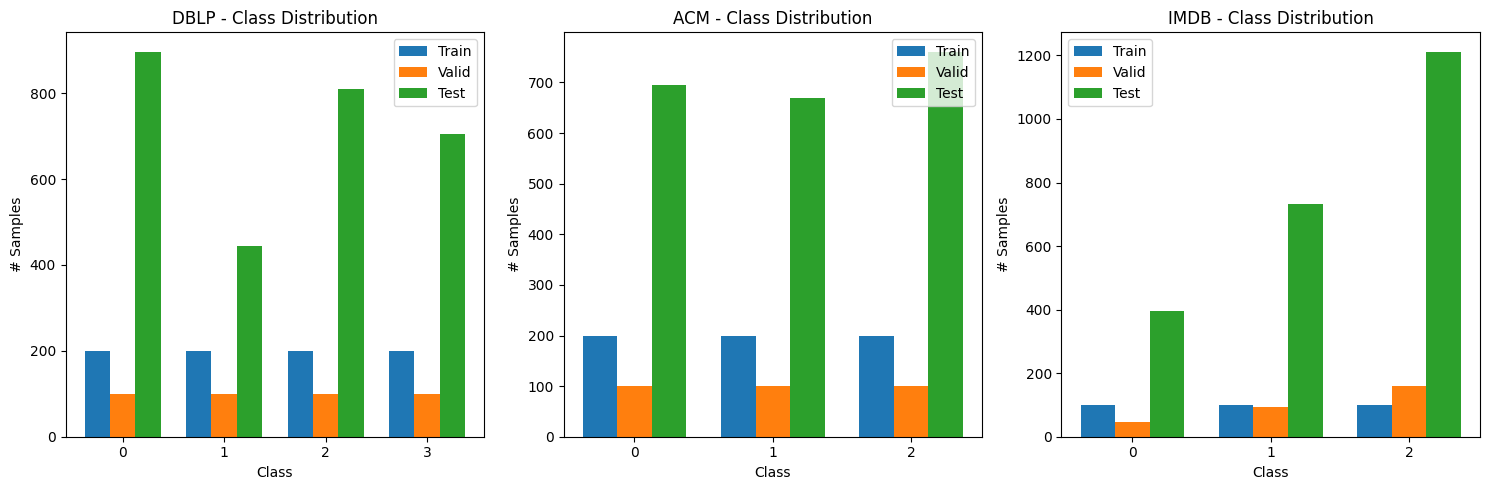

In [11]:
# Visualize class distributions across train/valid/test splits
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, name in enumerate(DATASETS):
    _, _, labels = datasets[name]
    
    train_labels = np.array(labels[0])[:, 1]
    valid_labels = np.array(labels[1])[:, 1]
    test_labels = np.array(labels[2])[:, 1]
    
    all_labels = np.concatenate([train_labels, valid_labels, test_labels])
    num_classes = len(np.unique(all_labels))
    
    # Count per class per split
    x = np.arange(num_classes)
    width = 0.25
    
    train_counts = [np.sum(train_labels == c) for c in range(num_classes)]
    valid_counts = [np.sum(valid_labels == c) for c in range(num_classes)]
    test_counts = [np.sum(test_labels == c) for c in range(num_classes)]
    
    axes[idx].bar(x - width, train_counts, width, label='Train', color='#1f77b4')
    axes[idx].bar(x, valid_counts, width, label='Valid', color='#ff7f0e')
    axes[idx].bar(x + width, test_counts, width, label='Test', color='#2ca02c')
    
    axes[idx].set_title(f'{name} - Class Distribution')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('# Samples')
    axes[idx].set_xticks(x)
    axes[idx].legend()

plt.tight_layout()
plt.show()

## 6. Graph Structure Analysis

In [12]:
print("=" * 80)
print("GRAPH STRUCTURE ANALYSIS")
print("=" * 80)

for name in DATASETS:
    node_features, edges, labels = datasets[name]
    print(f"\n--- {name} ---")
    
    num_nodes = node_features.shape[0]
    
    # Combine all edge types to get overall adjacency
    combined_adj = sum(edges)
    combined_adj = (combined_adj > 0).astype(int)  # Binary adjacency
    
    # Degree statistics
    out_degrees = np.array(combined_adj.sum(axis=1)).flatten()
    in_degrees = np.array(combined_adj.sum(axis=0)).flatten()
    
    print(f"Combined adjacency (all edge types):")
    print(f"  Total unique edges: {combined_adj.nnz}")
    print(f"  Out-degree - Min: {out_degrees.min()}, Max: {out_degrees.max()}, Mean: {out_degrees.mean():.2f}")
    print(f"  In-degree  - Min: {in_degrees.min()}, Max: {in_degrees.max()}, Mean: {in_degrees.mean():.2f}")
    
    # Check for isolated nodes
    total_degree = out_degrees + in_degrees
    isolated = np.sum(total_degree == 0)
    print(f"  Isolated nodes: {isolated}")
    
    # Check symmetry of edge types (A_ij should equal A_ji.T for relation pairs)
    print(f"\nEdge type symmetry check:")
    for i in range(0, len(edges), 2):
        if i + 1 < len(edges):
            diff = (edges[i] - edges[i+1].T).nnz
            print(f"  Type {i} vs Type {i+1}.T difference: {diff} edges")

GRAPH STRUCTURE ANALYSIS

--- DBLP ---
Combined adjacency (all edge types):
  Total unique edges: 67946
  Out-degree - Min: 1, Max: 1814, Mean: 3.69
  In-degree  - Min: 1, Max: 1814, Mean: 3.69
  Isolated nodes: 0

Edge type symmetry check:
  Type 0 vs Type 1.T difference: 0 edges
  Type 2 vs Type 3.T difference: 0 edges

--- ACM ---
Combined adjacency (all edge types):
  Total unique edges: 25922
  Out-degree - Min: 1, Max: 1190, Mean: 2.88
  In-degree  - Min: 1, Max: 1190, Mean: 2.88
  Isolated nodes: 0

Edge type symmetry check:
  Type 0 vs Type 1.T difference: 0 edges
  Type 2 vs Type 3.T difference: 0 edges

--- IMDB ---
Combined adjacency (all edge types):
  Total unique edges: 37288
  Out-degree - Min: 1, Max: 53, Mean: 2.92
  In-degree  - Min: 1, Max: 53, Mean: 2.92
  Isolated nodes: 0

Edge type symmetry check:
  Type 0 vs Type 1.T difference: 0 edges
  Type 2 vs Type 3.T difference: 0 edges


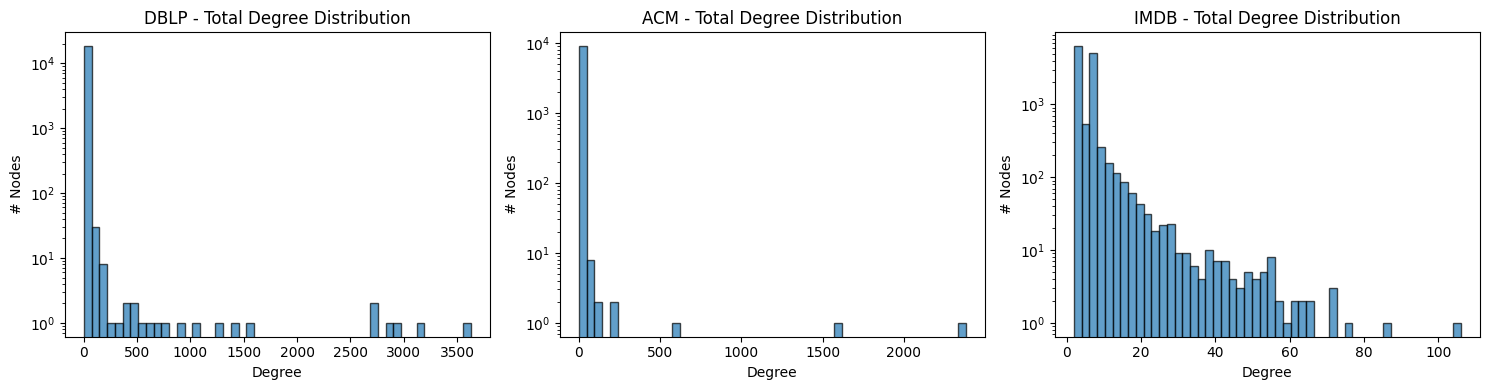

In [13]:
# Visualize degree distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, name in enumerate(DATASETS):
    node_features, edges, _ = datasets[name]
    
    # Combined adjacency
    combined_adj = sum(edges)
    degrees = np.array(combined_adj.sum(axis=1)).flatten() + np.array(combined_adj.sum(axis=0)).flatten()
    
    axes[idx].hist(degrees, bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{name} - Total Degree Distribution')
    axes[idx].set_xlabel('Degree')
    axes[idx].set_ylabel('# Nodes')
    axes[idx].set_yscale('log')

plt.tight_layout()
plt.show()

## 7. Labeled vs Unlabeled Nodes

In [14]:
print("=" * 80)
print("LABELED vs UNLABELED NODES")
print("=" * 80)

for name in DATASETS:
    node_features, edges, labels = datasets[name]
    print(f"\n--- {name} ---")
    
    num_nodes = node_features.shape[0]
    
    train_nodes = set(np.array(labels[0])[:, 0])
    valid_nodes = set(np.array(labels[1])[:, 0])
    test_nodes = set(np.array(labels[2])[:, 0])
    
    labeled_nodes = train_nodes | valid_nodes | test_nodes
    unlabeled_nodes = num_nodes - len(labeled_nodes)
    
    print(f"Total nodes: {num_nodes}")
    print(f"Labeled nodes: {len(labeled_nodes)} ({len(labeled_nodes)/num_nodes*100:.2f}%)")
    print(f"  - Train: {len(train_nodes)}")
    print(f"  - Valid: {len(valid_nodes)}")
    print(f"  - Test: {len(test_nodes)}")
    print(f"Unlabeled nodes: {unlabeled_nodes} ({unlabeled_nodes/num_nodes*100:.2f}%)")
    
    # Check for overlap
    train_valid_overlap = len(train_nodes & valid_nodes)
    train_test_overlap = len(train_nodes & test_nodes)
    valid_test_overlap = len(valid_nodes & test_nodes)
    print(f"\nSplit overlaps (should be 0):")
    print(f"  Train-Valid: {train_valid_overlap}")
    print(f"  Train-Test: {train_test_overlap}")
    print(f"  Valid-Test: {valid_test_overlap}")

LABELED vs UNLABELED NODES

--- DBLP ---
Total nodes: 18405
Labeled nodes: 4057 (22.04%)
  - Train: 800
  - Valid: 400
  - Test: 2857
Unlabeled nodes: 14348 (77.96%)

Split overlaps (should be 0):
  Train-Valid: 0
  Train-Test: 0
  Valid-Test: 0

--- ACM ---
Total nodes: 8994
Labeled nodes: 3025 (33.63%)
  - Train: 600
  - Valid: 300
  - Test: 2125
Unlabeled nodes: 5969 (66.37%)

Split overlaps (should be 0):
  Train-Valid: 0
  Train-Test: 0
  Valid-Test: 0

--- IMDB ---
Total nodes: 12772
Labeled nodes: 2939 (23.01%)
  - Train: 300
  - Valid: 300
  - Test: 2339
Unlabeled nodes: 9833 (76.99%)

Split overlaps (should be 0):
  Train-Valid: 0
  Train-Test: 0
  Valid-Test: 0


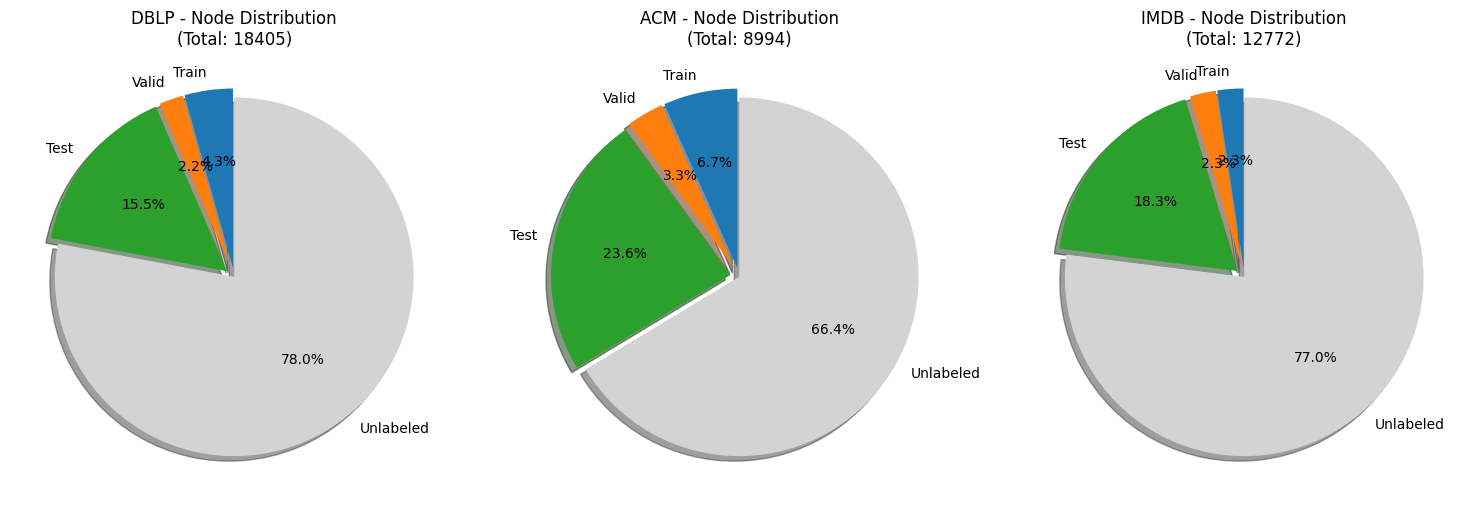

In [15]:
# Visualize labeled vs unlabeled
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, name in enumerate(DATASETS):
    node_features, _, labels = datasets[name]
    num_nodes = node_features.shape[0]
    
    train_count = len(labels[0])
    valid_count = len(labels[1])
    test_count = len(labels[2])
    unlabeled_count = num_nodes - train_count - valid_count - test_count
    
    sizes = [train_count, valid_count, test_count, unlabeled_count]
    labels_pie = ['Train', 'Valid', 'Test', 'Unlabeled']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d3d3d3']
    explode = (0.05, 0.05, 0.05, 0)
    
    axes[idx].pie(sizes, explode=explode, labels=labels_pie, colors=colors,
                  autopct='%1.1f%%', shadow=True, startangle=90)
    axes[idx].set_title(f'{name} - Node Distribution\n(Total: {num_nodes})')

plt.tight_layout()
plt.show()

## 8. Summary Comparison with Paper

In [16]:
# Paper reported values
paper_stats = pd.DataFrame({
    'Dataset': ['DBLP', 'ACM', 'IMDB'],
    '# Nodes': [18405, 8994, 12772],
    '# Edges': [67946, 25922, 37288],
    '# Edge Types': [4, 4, 4],
    '# Features': [334, 1902, 1256],
    '# Training': [800, 600, 300],
    '# Validation': [400, 300, 300],
    '# Test': [2857, 2125, 2339],
}).set_index('Dataset')

# Our computed values
our_stats = pd.DataFrame(stats_list).set_index('Dataset')[['# Nodes', '# Total Edges', '# Edge Types', '# Features', '# Training', '# Validation', '# Test']]
our_stats.columns = ['# Nodes', '# Edges', '# Edge Types', '# Features', '# Training', '# Validation', '# Test']

print("=" * 80)
print("VERIFICATION: Our Data vs Paper Table 1")
print("=" * 80)
print("\nPaper reported values:")
print(paper_stats)
print("\nOur computed values:")
print(our_stats)
print("\nMatch check:")
match = (paper_stats == our_stats).all().all()
print(f"All values match: {match}")

VERIFICATION: Our Data vs Paper Table 1

Paper reported values:
         # Nodes  # Edges  # Edge Types  # Features  # Training  # Validation  \
Dataset                                                                         
DBLP       18405    67946             4         334         800           400   
ACM         8994    25922             4        1902         600           300   
IMDB       12772    37288             4        1256         300           300   

         # Test  
Dataset          
DBLP       2857  
ACM        2125  
IMDB       2339  

Our computed values:
         # Nodes  # Edges  # Edge Types  # Features  # Training  # Validation  \
Dataset                                                                         
DBLP       18405    67946             4         334         800           400   
ACM         8994    25922             4        1902         600           300   
IMDB       12772    37288             4        1256         300           300   

         # T

## 9. Freebase Book Dataset Analysis

This section analyzes the Freebase Book dataset, which is a heterogeneous graph dataset for node classification based on book genres.


In [19]:
# Load Freebase Book dataset
FREEBASE_PATH = 'extension/Freebase_book'

with open(f'{FREEBASE_PATH}/node_features.pkl', 'rb') as f:
    fb_node_features = pickle.load(f)
with open(f'{FREEBASE_PATH}/edges.pkl', 'rb') as f:
    fb_edges = pickle.load(f)
with open(f'{FREEBASE_PATH}/labels.pkl', 'rb') as f:
    fb_labels = pickle.load(f)

print("Freebase Book dataset loaded successfully!")
print(f"Node features type: {type(fb_node_features)}")
print(f"Edges type: {type(fb_edges)}, length: {len(fb_edges)}")
print(f"Labels type: {type(fb_labels)}, length: {len(fb_labels)}")


Freebase Book dataset loaded successfully!
Node features type: <class 'numpy.ndarray'>
Edges type: <class 'list'>, length: 4
Labels type: <class 'list'>, length: 3


### 9.1 Node Statistics


In [ ]:
print("=" * 80)
print("FREEBASE BOOK - NODE STATISTICS")
print("=" * 80)

# Node features analysis
print(f"\nNode Features:")
print(f"  Shape: {fb_node_features.shape}")
print(f"  Type: {type(fb_node_features).__name__}")
if hasattr(fb_node_features, 'dtype'):
    print(f"  Dtype: {fb_node_features.dtype}")

# Convert to dense if sparse
if sp.issparse(fb_node_features):
    print(f"  Format: Sparse ({type(fb_node_features).__name__})")
    fb_features_dense = fb_node_features.toarray()
else:
    fb_features_dense = np.array(fb_node_features)
    print(f"  Format: Dense")

print(f"  Min: {fb_features_dense.min():.4f}, Max: {fb_features_dense.max():.4f}")
print(f"  Mean: {fb_features_dense.mean():.4f}, Std: {fb_features_dense.std():.4f}")

# Check sparsity
sparsity = (fb_features_dense == 0).sum() / fb_features_dense.size * 100
print(f"  Feature Sparsity: {sparsity:.2f}%")

# Check unique values
unique_vals = np.unique(fb_features_dense)
if len(unique_vals) <= 10:
    print(f"  Unique values: {unique_vals[:10]}")
else:
    print(f"  Number of unique values: {len(unique_vals)}")

# Note about node types based on conversion script
print(f"\nNode Type Distribution (from conversion script):")
print("  The dataset contains 3 node types in unified space:")
print("  - BOOK: Target nodes for classification (first segment)")  
print("  - PEOPLE: Connected to books via authorship (middle segment)")
print("  - ORGANIZATION: Publishers/organizations (last segment)")
print(f"  Total nodes: {fb_node_features.shape[0]}")


FREEBASE BOOK - NODE STATISTICS

Node Features:
  Shape: (38128, 2000)
  Type: ndarray
  Dtype: float32
  Format: Dense
  Min: 0.0000, Max: 1.0000
  Mean: 0.0006, Std: 0.0219
  Feature Sparsity: 99.88%
  Number of unique values: 46512

Node Type Distribution (from conversion script):
  The dataset contains 3 node types in unified space:
  - BOOK: Target nodes for classification (first segment)
  - PEOPLE: Connected to books via authorship (middle segment)
  - ORGANIZATION: Publishers/organizations (last segment)
  Total nodes: 38128


### 9.2 Edge Types Analysis


In [21]:
print("=" * 80)
print("FREEBASE BOOK - EDGE TYPES ANALYSIS")
print("=" * 80)

# Edge type names based on schema (similar to DBLP: PA, AP, PC, CP)
FB_EDGE_TYPE_NAMES = [
    'Book-People (BP)',      # Books written by people
    'People-Book (PB)',      # People who wrote books (transpose of BP)
    'Book-Org (BO)',         # Books published by organizations
    'Org-Book (OB)'          # Organizations that published books (transpose of BO)
]

print(f"\nNumber of edge types: {len(fb_edges)}")

total_edges = 0
edge_stats = []

for i, edge in enumerate(fb_edges):
    edge_name = FB_EDGE_TYPE_NAMES[i] if i < len(FB_EDGE_TYPE_NAMES) else f'Type {i}'
    print(f"\n  {edge_name}:")
    print(f"    Shape: {edge.shape}")
    print(f"    Format: {type(edge).__name__}")
    print(f"    # Edges: {edge.nnz}")
    density = edge.nnz / (edge.shape[0] * edge.shape[1]) * 100
    print(f"    Density: {density:.6f}%")
    
    total_edges += edge.nnz
    edge_stats.append({'name': edge_name, 'count': edge.nnz, 'density': density})

print(f"\nTotal edges (all types): {total_edges}")
print(f"Unique edges (removing transposes): {total_edges // 2}")

# Check symmetry
print(f"\nEdge type symmetry check:")
for i in range(0, len(fb_edges), 2):
    if i + 1 < len(fb_edges):
        diff = (fb_edges[i] - fb_edges[i+1].T).nnz
        print(f"  Type {i} ({FB_EDGE_TYPE_NAMES[i]}) vs Type {i+1}.T: difference = {diff} edges")


FREEBASE BOOK - EDGE TYPES ANALYSIS

Number of edge types: 4

  Book-People (BP):
    Shape: (38128, 38128)
    Format: csr_matrix
    # Edges: 16567
    Density: 0.001140%

  People-Book (PB):
    Shape: (38128, 38128)
    Format: csr_matrix
    # Edges: 16567
    Density: 0.001140%

  Book-Org (BO):
    Shape: (38128, 38128)
    Format: csr_matrix
    # Edges: 15724
    Density: 0.001082%

  Org-Book (OB):
    Shape: (38128, 38128)
    Format: csr_matrix
    # Edges: 15724
    Density: 0.001082%

Total edges (all types): 64582
Unique edges (removing transposes): 32291

Edge type symmetry check:
  Type 0 (Book-People (BP)) vs Type 1.T: difference = 0 edges
  Type 2 (Book-Org (BO)) vs Type 3.T: difference = 0 edges


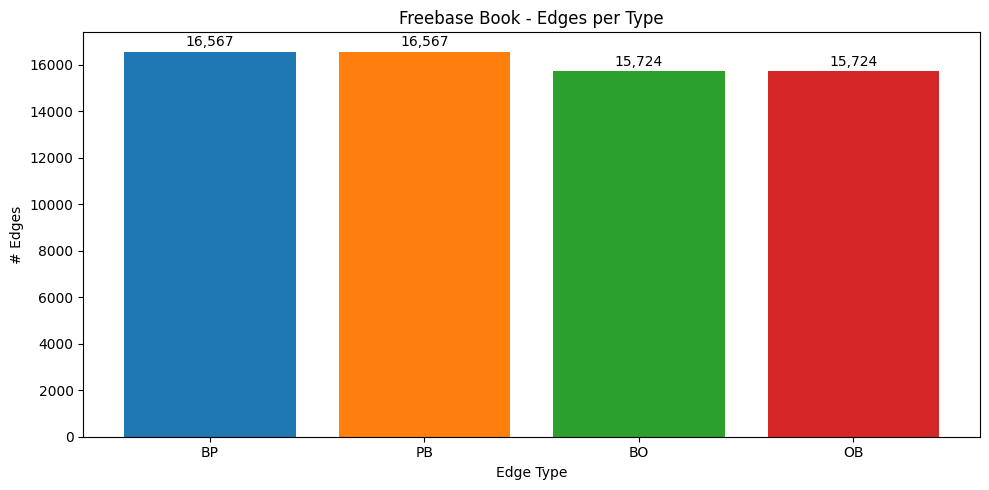

In [22]:
# Visualize edge type distribution
fig, ax = plt.subplots(figsize=(10, 5))

edge_counts = [e.nnz for e in fb_edges]
edge_labels = [en.split('(')[1].replace(')', '') for en in FB_EDGE_TYPE_NAMES[:len(fb_edges)]]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

bars = ax.bar(range(len(fb_edges)), edge_counts, color=colors[:len(fb_edges)])
ax.set_title('Freebase Book - Edges per Type')
ax.set_xlabel('Edge Type')
ax.set_ylabel('# Edges')
ax.set_xticks(range(len(fb_edges)))
ax.set_xticklabels(edge_labels)

# Add value labels on bars
for bar, count in zip(bars, edge_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
            f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


### 9.3 Labels Analysis (Book Genres)


In [ ]:
print("=" * 80)
print("FREEBASE BOOK - LABELS ANALYSIS")
print("=" * 80)

fb_train_labels = np.array(fb_labels[0])
fb_valid_labels = np.array(fb_labels[1])
fb_test_labels = np.array(fb_labels[2])

print(f"\nLabels format: list of 3 arrays [train, valid, test]")
print(f"Each array shape: [num_samples, 2] where columns are [node_idx, class_label]")
print(f"\nTrain labels shape: {fb_train_labels.shape}")
print(f"Valid labels shape: {fb_valid_labels.shape}")
print(f"Test labels shape: {fb_test_labels.shape}")

# Total labeled samples
total_labeled = len(fb_train_labels) + len(fb_valid_labels) + len(fb_test_labels)
print(f"\nTotal labeled nodes: {total_labeled}")

# Train/Val/Test split ratio
print(f"\nSplit ratios:")
print(f"  Train: {len(fb_train_labels)} ({len(fb_train_labels)/total_labeled*100:.1f}%)")
print(f"  Valid: {len(fb_valid_labels)} ({len(fb_valid_labels)/total_labeled*100:.1f}%)")
print(f"  Test: {len(fb_test_labels)} ({len(fb_test_labels)/total_labeled*100:.1f}%)")
print(f"  Train:Val ratio = {len(fb_train_labels)/len(fb_valid_labels):.2f}:1")

# Class distribution
fb_all_labels = np.concatenate([fb_train_labels[:, 1], fb_valid_labels[:, 1], fb_test_labels[:, 1]])
unique_classes, counts = np.unique(fb_all_labels, return_counts=True)
print(f"\nNumber of classes: {len(unique_classes)}")
print(f"Class labels: {unique_classes}")
print(f"\nClass distribution:")
for cls, cnt in zip(unique_classes, counts):
    print(f"  Class {cls}: {cnt} samples ({cnt/total_labeled*100:.1f}%)")


In [ ]:
# Visualize class distribution across splits
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Per-split class distribution
num_classes = len(unique_classes)
x = np.arange(num_classes)
width = 0.25

train_counts = [np.sum(fb_train_labels[:, 1] == c) for c in unique_classes]
valid_counts = [np.sum(fb_valid_labels[:, 1] == c) for c in unique_classes]
test_counts = [np.sum(fb_test_labels[:, 1] == c) for c in unique_classes]

axes[0].bar(x - width, train_counts, width, label='Train', color='#1f77b4')
axes[0].bar(x, valid_counts, width, label='Valid', color='#ff7f0e')
axes[0].bar(x + width, test_counts, width, label='Test', color='#2ca02c')
axes[0].set_title('Freebase Book - Class Distribution by Split')
axes[0].set_xlabel('Class (Book Genre)')
axes[0].set_ylabel('# Samples')
axes[0].set_xticks(x)
axes[0].set_xticklabels([f'Class {c}' for c in unique_classes], rotation=45)
axes[0].legend()

# Overall class distribution
axes[1].bar(unique_classes, counts, color='#9467bd')
axes[1].set_title('Freebase Book - Overall Class Distribution')
axes[1].set_xlabel('Class (Book Genre)')
axes[1].set_ylabel('# Samples')
axes[1].set_xticks(unique_classes)

# Add value labels
for i, (cls, cnt) in enumerate(zip(unique_classes, counts)):
    axes[1].text(cls, cnt + 20, str(cnt), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


### 9.4 Summary Comparison with Paper Datasets


In [ ]:
print("=" * 80)
print("COMPARISON: Freebase Book vs Paper Datasets (DBLP, ACM)")
print("=" * 80)

# Compute Freebase Book stats
fb_num_nodes = fb_node_features.shape[0]
fb_num_features = fb_node_features.shape[1]
fb_num_edge_types = len(fb_edges)
fb_total_edges = sum(e.nnz for e in fb_edges)
fb_num_classes = len(unique_classes)
fb_train = len(fb_train_labels)
fb_valid = len(fb_valid_labels)
fb_test = len(fb_test_labels)

# Create comparison table
comparison_data = {
    'Metric': ['# Nodes', '# Features', '# Edge Types', '# Total Edges', 
               '# Classes', '# Training', '# Validation', '# Test',
               'Train:Val Ratio', 'Labeled Ratio'],
    'Freebase Book': [
        fb_num_nodes, fb_num_features, fb_num_edge_types, fb_total_edges,
        fb_num_classes, fb_train, fb_valid, fb_test,
        f"{fb_train/fb_valid:.2f}:1", 
        f"{(fb_train+fb_valid+fb_test)/fb_num_nodes*100:.1f}%"
    ],
    'DBLP': [
        18405, 334, 4, 67946, 4, 800, 400, 2857, 
        "2.00:1", f"{(800+400+2857)/18405*100:.1f}%"
    ],
    'ACM': [
        8994, 1902, 4, 25922, 3, 600, 300, 2125,
        "2.00:1", f"{(600+300+2125)/8994*100:.1f}%"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df.set_index('Metric', inplace=True)
print("\n")
print(comparison_df.to_string())

print("\n" + "=" * 80)
print("Key Observations:")
print("=" * 80)
print(f"1. Freebase Book has {fb_num_nodes:,} nodes - larger than both DBLP and ACM")
print(f"2. Feature dimension ({fb_num_features}) uses TF-IDF BoW from book titles")
print(f"3. Has {fb_num_classes} classes (book genres) vs 4 (DBLP) and 3 (ACM)")
print(f"4. Same graph structure: 4 edge types with transpose pairs")
print(f"5. Similar node type schema: Target-Person-Organization (like Paper-Author-Venue)")


In [ ]:
# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

datasets_compare = ['Freebase Book', 'DBLP', 'ACM']
colors = ['#e74c3c', '#3498db', '#2ecc71']

# Nodes comparison
nodes = [fb_num_nodes, 18405, 8994]
axes[0].bar(datasets_compare, nodes, color=colors)
axes[0].set_title('Number of Nodes')
axes[0].set_ylabel('# Nodes')
for i, v in enumerate(nodes):
    axes[0].text(i, v + 500, f'{v:,}', ha='center', fontsize=10)

# Edges comparison
edges = [fb_total_edges, 67946, 25922]
axes[1].bar(datasets_compare, edges, color=colors)
axes[1].set_title('Total Number of Edges')
axes[1].set_ylabel('# Edges')
for i, v in enumerate(edges):
    axes[1].text(i, v + 2000, f'{v:,}', ha='center', fontsize=10)

# Classes comparison
classes = [fb_num_classes, 4, 3]
axes[2].bar(datasets_compare, classes, color=colors)
axes[2].set_title('Number of Classes')
axes[2].set_ylabel('# Classes')
for i, v in enumerate(classes):
    axes[2].text(i, v + 0.2, str(v), ha='center', fontsize=10)

plt.tight_layout()
plt.show()
